In [1]:
# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image, ImageDraw, ImageFilter, ImageFont
import os
from pathlib import Path
import mimetypes
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import itertools
import logging
from os.path import splitext
from os import listdir
from torch.utils.data import Dataset
from torchvision.models import resnet34
from torchvision.transforms import Compose

os.environ["TORCH_HOME"] = "C:/Users/Yash/Downloads/dense haze images/Useful"

In [2]:
# %%
path = "C:/Users/Yash/Downloads/dense haze images"
path_hr = path + "/GT"
path_lr = path + "/hazy"

In [3]:
# %%


def plot_img_and_mask(img, mask):
    classes = mask.shape[2] if len(mask.shape) > 2 else 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title("Input image")
    ax[0].imshow(img)
    if classes > 1:
        for i in range(classes):
            ax[i + 1].set_title(f"Output mask (class {i+1})")
            ax[i + 1].imshow(mask[:, :, i])
    else:
        ax[1].set_title(f"Output mask")
        ax[1].imshow(mask)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
# %%


class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        assert 0 < scale <= 1, "Scale must be between 0 and 1"

        self.ids = [
            splitext(file)[0] for file in listdir(imgs_dir) if not file.startswith(".")
        ]
        # self.c = len(self.ids)

    #         logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, "Scale is too small"
        pil_img = pil_img.resize((128, 128))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = self.masks_dir + "/" + idx + ".png"
        img_file = self.imgs_dir + "/" + idx + ".png"

        mask = Image.open(mask_file)
        img = Image.open(img_file)

        assert (
            img.size == mask.size
        ), f"Image and mask {idx} should be the same size, but are {img.size} and {mask.size}"

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)

        return (
            torch.from_numpy(img).type(torch.FloatTensor),
            torch.from_numpy(mask).type(torch.FloatTensor),
        )

In [9]:
# %%
dataset = BasicDataset(path_hr, path_lr, scale=0.5)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/Yash/Downloads/dense haze images/normal'

In [7]:
dataset.__getitem__(1)[0].permute(1, 2, 0).shape

NameError: name 'dataset' is not defined

In [ ]:
# %%
plt.imshow(dataset.__getitem__(1)[0].permute(1, 2, 0))

NameError: name 'dataset' is not defined

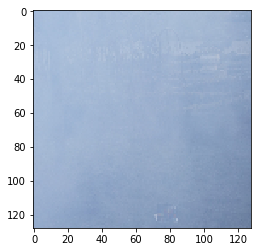

In [8]:
# %%
plt.imshow(dataset.__getitem__(1)[1].permute(1, 2, 0))

# inits

In [9]:
# %%
def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)


def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        # nn.init.normal_(m.weight, std=0.001)
        # nn.init.normal_(m.bias, std=0.001)
        truncated_normal_(m.bias, mean=0, std=0.001)

# Blocks for Unet

In [10]:
class DownConvBlock(nn.Module):
    def __init__(self, input_dim, output_dim, initializers, padding, pool=True):
        super(DownConvBlock, self).__init__()
        layers = []

        if pool:
            layers.append(
                nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True)
            )

        layers.append(
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)
            )
        )
        layers.append(nn.ReLU(inplace=True))
        layers.append(
            nn.Conv2d(
                output_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)
            )
        )
        layers.append(nn.ReLU(inplace=True))
        layers.append(
            nn.Conv2d(
                output_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)
            )
        )
        layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

        self.layers.apply(init_weights)

    def forward(self, patch):
        return self.layers(patch)

In [11]:
class UpConvBlock(nn.Module):
    def __init__(self, input_dim, output_dim, initializers, padding, bilinear=True):
        super(UpConvBlock, self).__init__()
        self.bilinear = bilinear

        if not self.bilinear:
            self.upconv_layer = nn.ConvTranspose2d(
                input_dim, output_dim, kernel_size=2, stride=2
            )
            self.upconv_layer.apply(init_weights)

        self.conv_block = DownConvBlock(
            input_dim, output_dim, initializers, padding, pool=False
        )

    def forward(self, x, bridge):
        if self.bilinear:
            up = nn.functional.interpolate(
                x, mode="bilinear", scale_factor=2, align_corners=True
            )
        else:
            up = self.upconv_layer(x)

        assert up.shape[3] == bridge.shape[3]
        out = torch.cat([up, bridge], 1)
        out = self.conv_block(out)

        return out


# Unet 

https://arxiv.org/abs/1505.04597

@article{DBLP:journals/corr/RonnebergerFB15,
  author    = {Olaf Ronneberger and
               Philipp Fischer and
               Thomas Brox},
  title     = {U-Net: Convolutional Networks for Biomedical Image Segmentation},
  journal   = {CoRR},
  volume    = {abs/1505.04597},
  year      = {2015},
  url       = {http://arxiv.org/abs/1505.04597},
  archivePrefix = {arXiv},
  eprint    = {1505.04597},
  timestamp = {Mon, 13 Aug 2018 16:46:52 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/RonnebergerFB15.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}



In [115]:
# %%
class Unet(nn.Module):
    def __init__(
        self,
        input_channels,
        num_classes,
        num_filters,
        initializers,
        apply_last_layer=True,
        padding=True,
    ):
        super(Unet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.padding = padding
        self.activation_maps = []
        self.apply_last_layer = apply_last_layer
        self.contracting_path = nn.ModuleList()
        #         self.pl = nn.modules.pixelshuffle

        for i in range(len(self.num_filters)):
            input = self.input_channels if i == 0 else output
            output = self.num_filters[i]

            if i == 0:
                pool = False
            else:
                pool = True

            self.contracting_path.append(
                DownConvBlock(input, output, initializers, padding, pool=pool)
            )

        self.upsampling_path = nn.ModuleList()

        n = len(self.num_filters) - 2
        for i in range(n, -1, -1):
            input = output + self.num_filters[i]
            output = self.num_filters[i]
            self.upsampling_path.append(
                UpConvBlock(input, output, initializers, padding)
            )

        if self.apply_last_layer:
            self.last_layer = nn.Conv2d(output, num_classes, kernel_size=1)
            # nn.init.kaiming_normal_(self.last_layer.weight, mode='fan_in',nonlinearity='relu')
            # nn.init.normal_(self.last_layer.bias)

    def forward(self, x, val):
        blocks = []
        for i, down in enumerate(self.contracting_path):
            x = down(x)
            if i != len(self.contracting_path) - 1:
                blocks.append(x)

        for i, up in enumerate(self.upsampling_path):
            x = up(x, blocks[-i - 1])

        del blocks

        # Used for saving the activations and plotting
        #         if val:
        #             self.activation_maps.append(x)

        if self.apply_last_layer:
            x = self.last_layer(x)
        #         x = self.pl(x)

        return x

In [116]:
# %%

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook, tqdm

In [117]:
def l2_regularisation(m):
    l2_reg = None

    for W in m.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return l2_reg

In [118]:
# %%
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.1 * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

In [119]:
#%%
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=16, sampler=test_sampler)
print("Number of training/test patches:", (len(train_indices), len(test_indices)))

Number of training/test patches: (50, 5)


In [120]:
import gc

In [190]:
net = None
gc.collect()

3991

In [191]:
# %%
net = Unet(
    input_channels=3,
    num_classes=3,
    num_filters=[32, 64, 128, 192],
    initializers={"w": "he_uniform", "b": "normal"},
)

In [192]:
net = net.to("cuda")

In [193]:
from tqdm import trange

In [195]:
# %%
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-5, weight_decay=10e-3)
criterion = nn.MSELoss(reduce="mean").to("cuda")

In [ ]:
epochs = 4000
t = trange(epochs, desc="ML")
epoch_loss = []
for epoch in t:

    net.train()
    for step, (patch, mask) in enumerate(train_loader):
        patch = patch.to("cuda")
        mask = mask.to("cuda")
        mask2 = torch.unsqueeze(mask, 1)
        ou = net.forward(patch, mask)
        #         print(mask.shape, ou.shape)
        loss = criterion(mask.squeeze(1), ou)
        epoch_loss.append(loss.item())
        t.set_description("ML (loss=%g)" % loss)
        optimizer.zero_grad()
        #         optimizer.zero_grad()
        loss.backward()
        #         optimizer2.step()
        optimizer.step()
    if epoch % 100 == 0:
        plt.cla()
        plt.clf()
        im = net.forward(patch, mask).__getitem__(1).permute(1, 2, 0)
        plt.imshow(im.cpu().detach().numpy())
        plt.savefig(f"intermediate/{epoch}.jpg")
    if epoch % 500 == 0:
        torch.save(net.state_dict(), "cpt/{}.pth".format(epoch))
        im = net.forward(patch, mask).__getitem__(1).permute(1, 2, 0)

ML (loss=0.000384583):  74%|███████▍  | 2965/4000 [3:37:37<1:13:41,  4.27s/it]

In [188]:
def save_im(ep):
    net.eval()
    for step, (patch, mask) in enumerate(train_loader):
        patch = patch.to("cuda")
        mask = mask.to("cuda")
        mask2 = torch.unsqueeze(mask, 1)
        im = net.forward(patch, mask).__getitem__(1).permute(1, 2, 0)
        print(im.shape)
        plt.imshow(im.cpu().detach().numpy())
        print(cur_e)
        plt.savefig(f"intermediate/{ep}.jpg")
        break